In [16]:
import os
import datetime
import requests

import pandas as pd
import geopandas as gpd
import shapely

import pyrosm
import r5py
import gtfs_kit as gk

from common_functions import setup_folders, generate_points_on_land, download_transitland_feeds_for_area, download_topography, scatter_plot, set_modules_to_autoreload

set_modules_to_autoreload()

parent_folder = "vancouver_travel_times"
setup_folders(parent_folder, ['osm', 'gtfs', 'topography'])

travel_date = "2026-01-05"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
#download osm data using pyrosm and save to vancouver-travel-times/osm/

osm = pyrosm.get_data("Vancouver", directory=f"{parent_folder}/osm/")

In [3]:
# Initialize the OSM object 
osm = pyrosm.OSM(parent_folder + "/osm/Vancouver.osm.pbf")

Centroid: [-123.05550053506508, 49.267769022745824]
Estimated UTM CRS: EPSG:32610
Number of points in x direction: 42
Number of points in y direction: 29
Generated 1218 grid points.
Centroid: [np.float64(-123.05560993059967), np.float64(49.2676969102175)]
Estimated UTM CRS: EPSG:32610
                        geometry
0  POINT (480134.022 5446366.51)
1  POINT (511712.33 5468112.078)
Aspect ratio (height/width): 0.6886235811958998


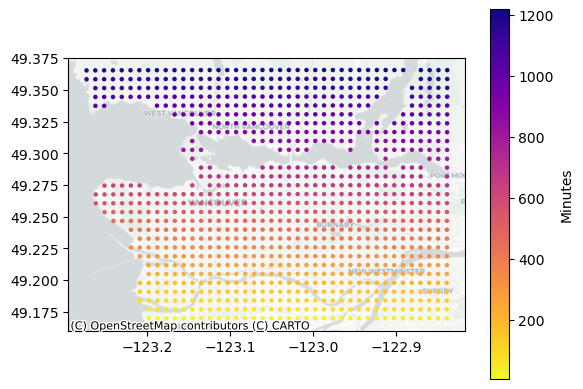

In [4]:
#get the bounding box of the osm data
#bbox = drive_net.total_bounds  # minx, miny, maxx, maxy
#print("OSM data bounding box:", bbox)

#p1, p2 = (bbox[0], bbox[1]), (bbox[2], bbox[3])

p1, p2 = (49.36334432367959, -123.27134437003016)[::-1], (49.17219372181205, -122.83965670010001)[::-1]

grid_points, land = generate_points_on_land(p1, p2, spacing=750)

scatter_plot(grid_points.geometry.x, grid_points.geometry.y, grid_points.id)

In [ ]:
download_transitland_feeds_for_area(p1, p2, travel_date, parent_folder + "/gtfs")

In [ ]:
#additional data cleaning for GTFS

gtfs_paths = [parent_folder + "/gtfs/" + name for name in os.listdir(parent_folder + "/gtfs/") if name.endswith(".zip")]    

#Some trips have arrival or departure times > 72:00:00 hours which r5py cannot handle. Find these trips and remove them from the feed, re-saving the feed to a .zip file

for path in gtfs_paths:
    feed = gk.read_feed(path, dist_units="km")

    #check if any stop_times have arrival or departure times higher than 72:00:00 hours
    max_seconds = 72 * 3600
    feed.stop_times.departure_time = pd.to_timedelta(feed.stop_times.departure_time).dt.total_seconds()
    feed.stop_times.arrival_time = pd.to_timedelta(feed.stop_times.arrival_time).dt.total_seconds()

    offending_trips = feed.stop_times[(feed.stop_times.departure_time > max_seconds) | (feed.stop_times.arrival_time > max_seconds)].trip_id.unique()

    if len(offending_trips) == 0:
        print("{} trips in feed {} have arrival/departure times > 72 hours. No pruning needed.".format(len(offending_trips), path))
        continue

    print("{} trips in feed {} have arrival/departure times > 72 hours. Pruning trips.".format(len(offending_trips), path))
    #delete offending trips from feed
    feed.stop_times = feed.stop_times[~feed.stop_times.trip_id.isin(offending_trips)]

    #convert back to hh:mm:ss format. Format as string
    feed.stop_times.departure_time = pd.to_timedelta(feed.stop_times.departure_time, unit='s').apply(lambda x: str(x).split(' ')[-1])
    feed.stop_times.arrival_time = pd.to_timedelta(feed.stop_times.arrival_time, unit='s').apply(lambda x: str(x).split(' ')[-1])
    #save modified feed back to zip file
    feed.to_file(path)
    
#check for shapes with only one point. Remove them, and find trips that use those shapes and remove them too
for path in gtfs_paths:
    feed = gk.read_feed(path, dist_units="km")

    shape_lengths = feed.shapes.groupby('shape_id').size()
    single_point_shapes = shape_lengths[shape_lengths == 1].index.tolist()

    if len(single_point_shapes) == 0:
        print("No single-point shapes found in feed {}".format(path))
        continue

    print("Found {} single-point shapes in feed {}. Pruning shapes and associated trips.".format(len(single_point_shapes), path))
    print("Single-point shape IDs:", single_point_shapes)
    print("Affected trip IDs:", feed.trips[feed.trips.shape_id.isin(single_point_shapes)].trip_id.unique().tolist())

    #remove single-point shapes
    feed.shapes = feed.shapes[~feed.shapes.shape_id.isin(single_point_shapes)]
    #remove trips that use those shapes
    feed.trips = feed.trips[~feed.trips.shape_id.isin(single_point_shapes)]
    #remove stop_times for those trips
    feed.stop_times = feed.stop_times[~feed.stop_times.trip_id.isin(feed.trips[feed.trips.shape_id.isin(single_point_shapes)].trip_id.unique())]

    #save modified feed back to zip file
    feed.to_file(path)


In [ ]:
download_topography(p1, p2, parent_folder)

In [5]:
gtfs_paths = [parent_folder + "/gtfs/" + name for name in os.listdir(parent_folder + "/gtfs/") if name.endswith(".zip")
              ]

transport_network = r5py.TransportNetwork(
    osm_pbf = parent_folder + "/osm/Vancouver.osm.pbf",
    gtfs = gtfs_paths,
    elevation_model = parent_folder + "/topography/topography-wgs.tif"

)

In [6]:
origins = grid_points.copy().reset_index(drop=True)
origins.geometry = origins.geometry.centroid

destinations = gpd.GeoDataFrame(
    {
        "id": ["waterfront"],
        "geometry": [shapely.Point(-123.11962475802599, 49.28547524141578)]
    },
    crs="EPSG:4326",
)

transit_travel_times = r5py.TravelTimeMatrix(
    transport_network,
    origins=origins,
    destinations=destinations,
    departure=datetime.datetime.strptime(travel_date + " 07:30", "%Y-%m-%d %H:%M"),
    transport_modes=[
        r5py.TransportMode.TRANSIT,
        r5py.TransportMode.WALK
    ],
    snap_to_network=False,
)

bike_travel_times = r5py.TravelTimeMatrix(
    transport_network,
    origins=origins,
    destinations=destinations,
    departure=datetime.datetime.strptime(travel_date + " 07:30", "%Y-%m-%d %H:%M"),
    transport_modes=[
        r5py.TransportMode.BICYCLE,
    ],
    snap_to_network=False,
    speed_cycling = 21.5
)

C:\Users\marki\AppData\Local\Temp\ipykernel_20020\3787057399.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  origins.geometry = origins.geometry.centroid


In [7]:
travel_times = origins.copy()

travel_times['transit'] = transit_travel_times.travel_time
travel_times['bike'] = bike_travel_times.travel_time

travel_times = travel_times.dropna()

sample = travel_times.sample(50, random_state=1)
sample['sample_id'] = range(len(sample))

Centroid: [np.float64(-123.0449393034005), np.float64(49.26767441235601)]
Estimated UTM CRS: EPSG:32610
                         geometry
0  POINT (481712.957 5446371.162)
1   POINT (511689.19 5468096.916)
Aspect ratio (height/width): 0.7247660087225632


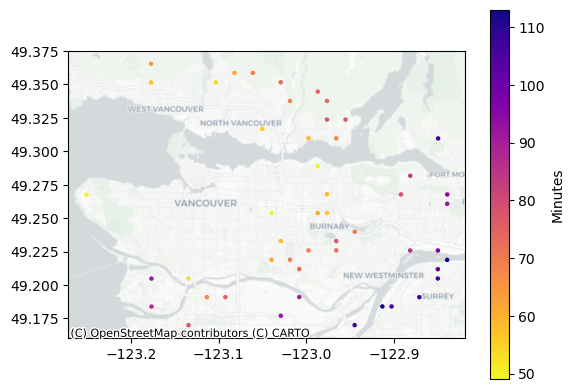

In [9]:

scatter_plot(
    sample.geometry.x,
    sample.geometry.y,
    sample.bike)

In [10]:
#calibration of cycling times against Google Maps API

MAPS_API_KEY = os.getenv("MAPS_PLATFORM_API_KEY")

# Google Maps Route Matrix API request - multiple origins to one destination
url = "https://routes.googleapis.com/distanceMatrix/v2:computeRouteMatrix"

# Convert sample points to proper API structure
origins_list = [
    {
        "waypoint": {
            "location": {
                "latLng": {
                    "latitude": lat,
                    "longitude": lon
                }
            }
        }
    }
    for lon, lat in zip(sample.geometry.x, sample.geometry.y)
]

# Destination
destination = destinations.iloc[0]
destinations_list = [
    {
        "waypoint": {
            "location": {
                "latLng": {
                    "latitude": destination.geometry.y,
                    "longitude": destination.geometry.x
                }
            }
        }
    }
]

payload = {
    "origins": origins_list,
    "destinations": destinations_list,
    "travelMode": "BICYCLE"
}

headers = {
    "Content-Type": "application/json",
    "X-Goog-Api-Key": MAPS_API_KEY,
    "X-Goog-FieldMask": "originIndex,destinationIndex,duration,distanceMeters,status,condition"
}

response = requests.post(url, json=payload, headers=headers)
results = response.json()

results

[{'originIndex': 43,
  'destinationIndex': 0,
  'status': {},
  'distanceMeters': 14173,
  'duration': '2849s',
  'condition': 'ROUTE_EXISTS'},
 {'originIndex': 49,
  'destinationIndex': 0,
  'status': {},
  'distanceMeters': 17086,
  'duration': '4016s',
  'condition': 'ROUTE_EXISTS'},
 {'originIndex': 20,
  'destinationIndex': 0,
  'status': {},
  'distanceMeters': 11112,
  'duration': '2708s',
  'condition': 'ROUTE_EXISTS'},
 {'originIndex': 13,
  'destinationIndex': 0,
  'status': {},
  'distanceMeters': 11288,
  'duration': '2195s',
  'condition': 'ROUTE_EXISTS'},
 {'originIndex': 28,
  'destinationIndex': 0,
  'status': {},
  'distanceMeters': 13797,
  'duration': '3203s',
  'condition': 'ROUTE_EXISTS'},
 {'originIndex': 34,
  'destinationIndex': 0,
  'status': {},
  'distanceMeters': 11261,
  'duration': '2583s',
  'condition': 'ROUTE_EXISTS'},
 {'originIndex': 7,
  'destinationIndex': 0,
  'status': {},
  'distanceMeters': 14263,
  'duration': '2743s',
  'condition': 'ROUTE_EXI

In [12]:
gmaps_df = pd.DataFrame(columns=["origin_id", "destination_id", "route_exists", "gmaps_travel_time", "distance"])

for result in results:
    new_row = {
        'origin_id': result['originIndex'],
        'destination_id': result['destinationIndex'],
        'route_exists': (result['condition'] == 'ROUTE_EXISTS'),
        'gmaps_travel_time': int(result['duration'].replace('s',''))/60 if result['condition'] == 'ROUTE_EXISTS' else None,
        'distance': result['distanceMeters'] if result['condition'] == 'ROUTE_EXISTS' else None
    }

    gmaps_df = pd.concat([gmaps_df, pd.DataFrame([new_row])], ignore_index=True)

comparison = sample.merge(gmaps_df, left_on = 'sample_id', right_on = 'origin_id')

C:\Users\marki\AppData\Local\Temp\ipykernel_20020\3482606344.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  gmaps_df = pd.concat([gmaps_df, pd.DataFrame([new_row])], ignore_index=True)


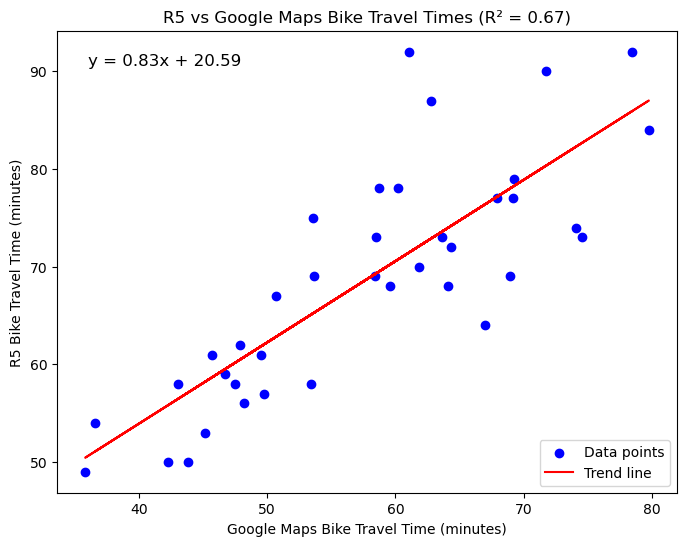

In [13]:
#plot comparison.gmaps_travel_time vs comparison.bike with matplotlib, compute regession, and show trend line and R2 value

#trim comparison - delete anything with gmaps travel time over 80 minutes
comparison = comparison[comparison.gmaps_travel_time <= 80]
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.scatter(comparison.gmaps_travel_time, comparison.bike, color='blue', label='Data points')
#compute regression
from sklearn.linear_model import LinearRegression
import numpy as np
X = comparison.gmaps_travel_time.values.reshape(-1, 1)
y = comparison.bike.values
reg = LinearRegression().fit(X, y)
y_pred = reg.predict(X)
plt.plot(comparison.gmaps_travel_time, y_pred, color='red', label='Trend line')
r2 = reg.score(X, y)

eqn_label = f'y = {reg.coef_[0]:.2f}x + {reg.intercept_:.2f}'

plt.text(0.05, 0.95, eqn_label, transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')
plt.xlabel('Google Maps Bike Travel Time (minutes)')
plt.ylabel('R5 Bike Travel Time (minutes)')
plt.title(f'R5 vs Google Maps Bike Travel Times (R² = {r2:.2f})')
plt.legend()

plt.show()

In [14]:
#adjust the bike travel times based on the regression (note that originally, the regression had gmaps on the X axis and r5 on the Y axis)

travel_times['adjusted bike'] = travel_times['bike'] / reg.coef_[0] - reg.intercept_
travel_times['delta'] = travel_times.transit - travel_times['adjusted bike']

761
X limits: (np.float64(-13721453.666818907), np.float64(-13675536.880826924))
Y limits: (np.float64(6304910.152885818), np.float64(6335931.683194933))
X limits: (np.float64(-13721453.666818907), np.float64(-13675536.880826924))
Y limits: (np.float64(6304910.152885818), np.float64(6335931.683194933))
X limits: (np.float64(-13721453.666818907), np.float64(-13675536.880826924))
Y limits: (np.float64(6304910.152885818), np.float64(6335931.683194933))


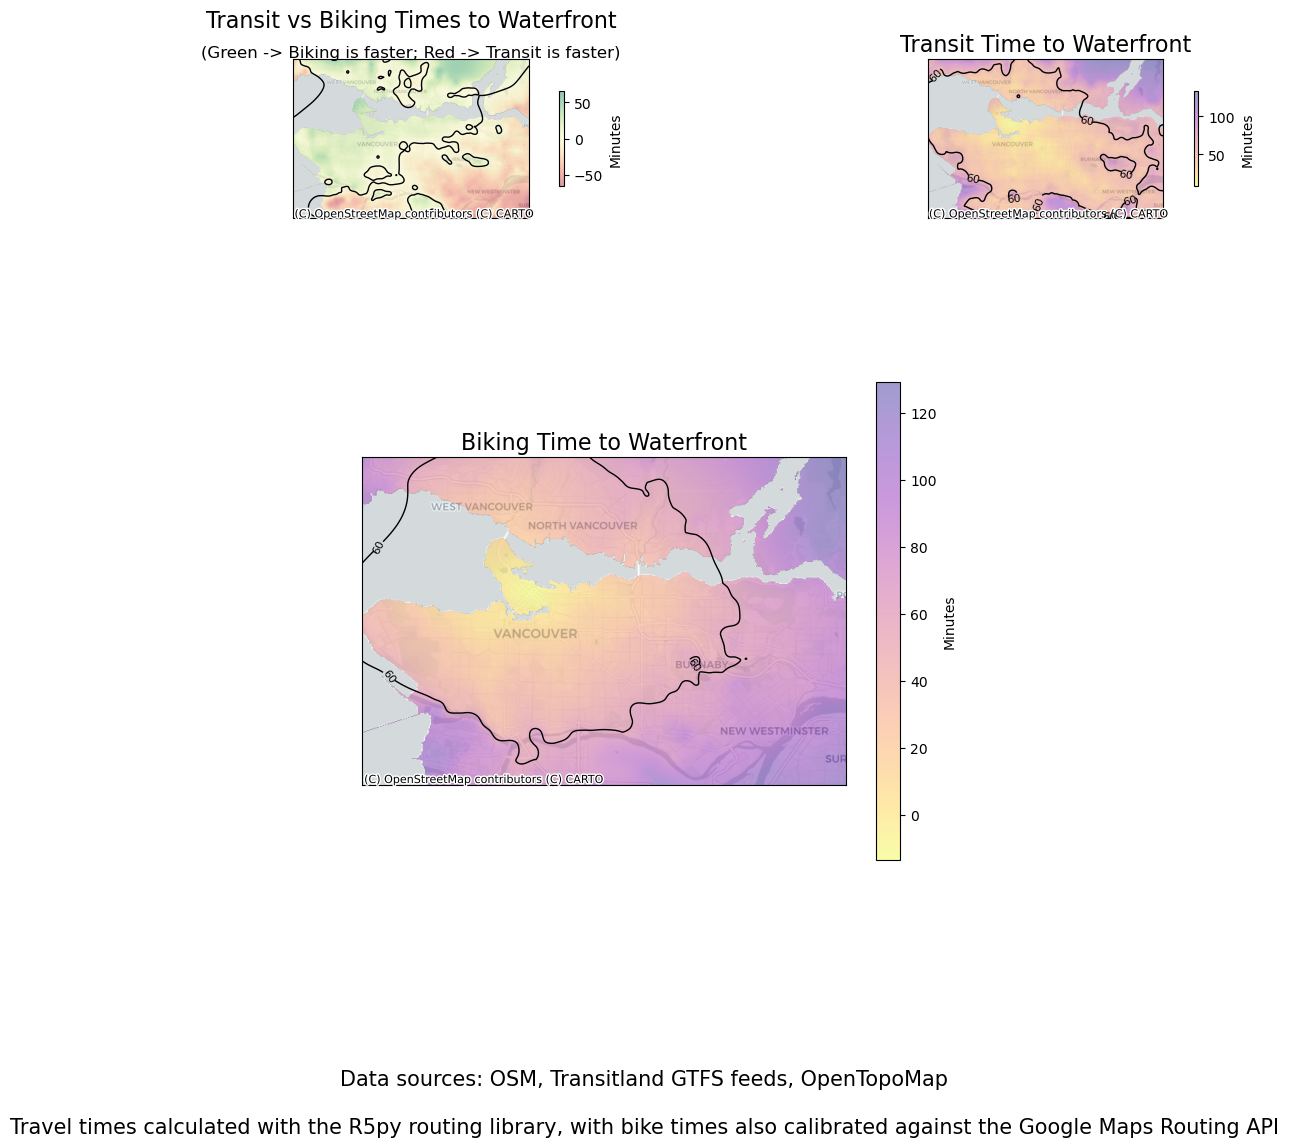

In [ ]:
import matplotlib.pyplot as plt
from common_functions import plot_interpolated_grid

#p3 = (49.25676113415463, -123.17739582109954)[::-1]
#p4 = (49.19733762312748, -123.06635611804826)[::-1]

p3 = p1
p4 = p2

#clip travel_times = by p3 and p4
box_gdf = shapely.box(p3[0], p3[1], p4[0], p4[1])
travel_times = travel_times.clip(box_gdf)
travel_times = travel_times.dropna()

print(len(travel_times))

# --- Create the shared figure and axes ---
fig = plt.figure(figsize=(16, 12))
gs = fig.add_gridspec(2, 4, hspace=0.01, wspace=0.1, height_ratios=[1, 1], top=0.92, bottom=0.12)

# Create axes with proper centering
ax1 = fig.add_subplot(gs[0, 0:2])  # First plot spans columns 0-1
ax2 = fig.add_subplot(gs[0, 2:4])  # Second plot spans columns 2-3
ax3 = fig.add_subplot(gs[1, 1:3])  # Third plot spans columns 1-2 (centered)

# --- First plot: Transit vs Bike delta ---
plot_interpolated_grid(
    travel_times.geometry.x,
    travel_times.geometry.y,
    travel_times['delta'],
    land=land,
    contours=[0],
    zero_centred=True,
    grid_size=400,
    cmap='RdYlGn',
    title="Transit vs Biking Times to Waterfront",
    sub_title="(Green -> Biking is faster; Red -> Transit is faster)",
    ax=ax1
)

# --- Second plot: Transit time ---
plot_interpolated_grid(
    travel_times.geometry.x,
    travel_times.geometry.y,
    travel_times['transit'],
    land=land,
    contours=[60],
    zero_centred=False,
    grid_size=400,
    cmap='plasma_r',
    title="Transit Time to Waterfront",
    ax=ax2
)

# --- Third plot: Bike time ---
plot_interpolated_grid(
    travel_times.geometry.x,
    travel_times.geometry.y,
    travel_times['adjusted bike'],
    land=land,
    contours=[60],
    zero_centred=False,
    grid_size=400,
    #additional_gdf=detailed_itineraries,
    cmap='plasma_r',
    title="Biking Time to Waterfront",
    ax=ax3
)

#add a note to the bottom of the figure
fig.text(0.5, .065, "Data sources: OSM, Transitland GTFS feeds, OpenTopoMap", ha='center', fontsize=15)

#add a second line to the bottom of the figure
fig.text(0.5, .025, "Travel times calculated with the R5py routing library, with bike times also calibrated against the Google Maps Routing API", ha='center', fontsize=15)

plt.show()